# Geospatial Indexing Explained

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from hilbertcurve.hilbertcurve import HilbertCurve
import pymorton

In [3]:
home = "../.."
images_dir = os.path.join(home, "static/images/")

Geohash level 3 (0.7° by 0.7°)

https://stackoverflow.com/a/39540339/7195218

## Cell Distortion

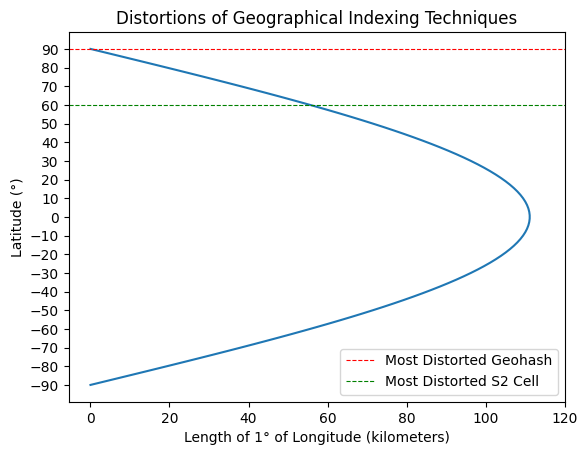

In [5]:
EARTH_RADIUS_KMS = 6371
latitude = np.linspace(-90, 90, 100)
one_degree_longitude_length = (np.pi / 180) * EARTH_RADIUS_KMS * np.cos(np.radians(latitude))
plt.plot(one_degree_longitude_length, latitude)
plt.xticks(np.arange(0, 140, 20))
plt.yticks(np.arange(-90, 100, 10))
plt.ylabel("Latitude (°)")
plt.xlabel("Length of 1° of Longitude (kilometers)")
plt.title("Distortions of Geographical Indexing Techniques")
plt.axhline(90, c="red", linestyle="dashed", linewidth=.8, label="Most Distorted Geohash")
plt.axhline(60, c="green", linestyle="dashed", linewidth=.8, label="Most Distorted S2 Cell")
plt.legend()
plt.savefig(os.path.join(images_dir, "longitude-distortion-of-geohash-s2.png"))
plt.show()

## S2

In [4]:
import s2cell

In [5]:
for level in range(1, 10):
    print(s2cell.lat_lon_to_cell_id(-11, 10, level))

2017612633061982208
1945555039024054272
1963569437533536256
1950058638651424768
1946680938930896896
1945836514000764928
1945625407768231936
1945642999954276352
1945647398000787456


## Bit Level Geohash Creation

In [64]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

lat_ranges = [(-90, 90), (-90, 90), (0, 90), (0, 90), (0, 45), (0, 45)]
lon_ranges = [(-180, 180), (-180, 0), (-180, 0), (-90, 0), (-90, 0), (-90, -45)]
image_base_height = 300

for i, (lat_range, lon_range) in enumerate(zip(lat_ranges, lon_ranges)):
    fig = px.line_geo(lat=[], lon=[], projection="equirectangular")
    fig.update_layout(
        height=image_base_height,
        width=image_base_height * 2 if i % 2 == 0 else image_base_height,
        margin={"r":0,"t":0,"l":0,"b":0}
    )
    fig.update_geos(**{
        "lataxis": {"range": lat_range},
        "lonaxis": {"range": lon_range},
    })
    fig.write_image(os.path.join(images_dir, f"geohash-bit-level-computation-level-{i}.png"))

## Z Order Curve on the Map

#### Level 1 geohashes

In [49]:
fig = go.Figure(go.Scattergeo())
fig = px.line_geo(lat=[], lon=[], projection="equirectangular")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(**{
    "lataxis": {
        "showgrid": True,
        "dtick": 45,
        "gridwidth": 2,
        "gridcolor": "#105484"
    },
    "lonaxis": {
        "showgrid": True,
        "dtick": 45,
        "gridwidth": 2,
        "gridcolor": "#105484"
    },
})
# fig.add_scatter(x=y_geo, y=x_geo, mode="lines")
# fig.add_traces(go.Scatter(x=y_geo, y=x_geo))
# fig.show()
fig.write_image(os.path.join(images_dir, "geohash-level-1-basemap.png"))

#### Level 2 geohashes

In [51]:
fig = go.Figure(go.Scattergeo())
fig = px.line_geo(lat=[], lon=[], projection="equirectangular")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(**{
    "lataxis": {
        "showgrid": True,
        "dtick": 45 / 8,
        "gridwidth": 2,
        "gridcolor": "#105484",
        "range": [0, 45]
    },
    "lonaxis": {
        "showgrid": True,
        "dtick": 45 / 4,
        "gridwidth": 2,
        "gridcolor": "#105484",
        "range": [45, 90]
    },
})
# fig.add_scatter(x=y_geo, y=x_geo, mode="lines")
# fig.add_traces(go.Scatter(x=y_geo, y=x_geo))
# fig.show()
fig.write_image(os.path.join(images_dir, "geohash-level-2-basemap.png"))

## Z Order vs Hilbert Curve

https://github.com/trevorprater/pymorton

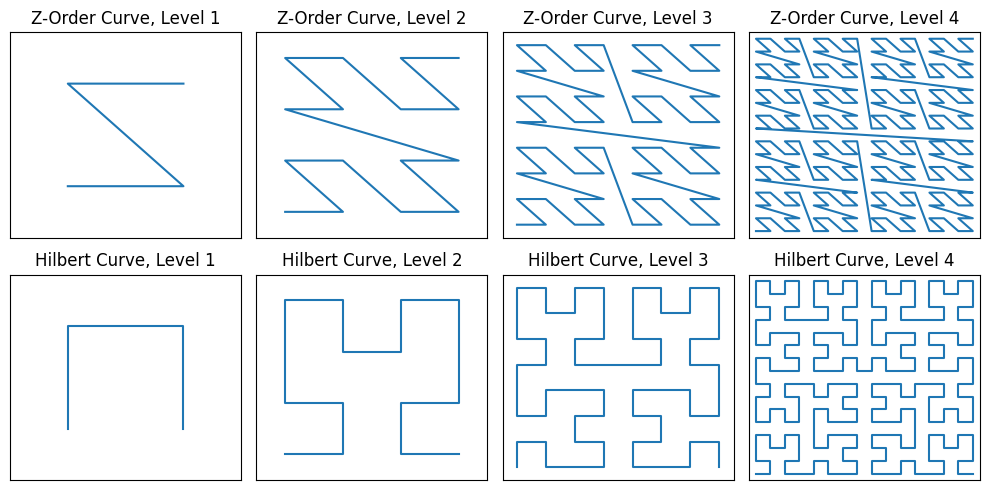

In [28]:
# set up the chart
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

# for three levels of the fractal curve
for i, curve_level in enumerate([1, 3, 5, 7]):

    # plot the Z Order Curve
    z_points = tuple(zip(*[pymorton.deinterleave2(index) for index in range(2 ** (curve_level + 1))]))
    axs[0, i].plot(*z_points)
    axs[0, i].set_title(f'Z-Order Curve, Level {i + 1}')

    # plot the Hilbert curve
    hilbert_curve = HilbertCurve(p=curve_level, n=2)
    distances = list(range(2 ** (curve_level + 1)))
    points = tuple(zip(*hilbert_curve.points_from_distances(distances)))
    x, y = (points[0], points[1]) if i % 2 == 0 else (points[1], points[0])
    axs[1, i].plot(x, y)
    axs[1, i].set_title(f'Hilbert Curve, Level {i + 1}')

    # Clear axes and set limits
    curve_buffer = .5
    for j in [0, 1]:
        axs[j, i].set_xticks([])
        axs[j, i].set_xlim([0 - curve_buffer, max(x) + curve_buffer])
        axs[j, i].set_yticks([])
        axs[j, i].set_ylim([0 - curve_buffer, max(x) + curve_buffer])

# Save figure
plt.tight_layout()
fig.savefig("../../static/images/z-order-curve-vs-hilbert-curve.svg")